# PN Diode Potential Prediction

Created on Mar 4, 2021

@author: Haoqing Xu @ICAC, IMECAS, xuhaoqing@ime.ac.cn

This project focus on a pn diode built-in potential prediction by neural network.

[Ref] Sung-Min Hong et. al. "Deep neural network for generation of the initial electrostatic potential profile." 2019SISPAD. IEEE, 2019.

In [1]:
import time
start = time.perf_counter()

# Import packages

In [2]:
import torch
import math
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd

# Data Loading

In [3]:
num_of_sample = 1156
num_of_point = 121

Y = np.empty([num_of_sample, num_of_point])

#for i in range(1):
for i in range(num_of_sample):
    input_file_name = "./dataset/potential%d.crv" %(i+1)
    read_in_file = np.loadtxt(input_file_name,dtype="float",delimiter=None, skiprows=1, usecols=None, unpack=False)
    #print(read_in_file)
    
    read_in_potential = read_in_file[0,3]
    for j in range(num_of_point-2):
        read_in_potential = np.append(read_in_potential, read_in_file[5+2*j, 3])
    read_in_potential = np.append(read_in_potential, read_in_file[-1, 3])
    
    read_in_potential = read_in_potential.reshape(1, num_of_point)
    Y[i,:] = read_in_potential[:,:]

print("Y shape is", Y.shape)

Y shape is (1156, 121)


In [4]:
X = np.zeros([num_of_sample, 2])
for j in range(num_of_sample):
    X[j, 0] = 1.0e15 + (j // 34) * 3.0e15
    X[j, 1] = 1.0e15 + (j % 34) * 3.0e15

#list(X)
print("X shape is", X.shape)

X shape is (1156, 2)


## Pre-processing

X(Column 1-2): acceptor_concentration,  donor_concentration

Y(Column 6-9): potential at 121 points

In [5]:
#ss_x, ss_y = StandardScaler(), StandardScaler()
#X = ss_x.fit_transform(X)
#Y = ss_y.fit_transform(Y)
#print('Scaled X\n', X)
#print('Scaled Y\n', Y)

#X2 = ss_x.inverse_transform(X1)
#Y = StandardScaler().fit_transform(Y)
#print('inverse_scaler\n', X2)

ATTENTION:  'ss = StandardScaler()' is necessary due to inverse_transform share u and s with fit_transform

Split trainSet and testset

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(578, 2) (578, 2) (578, 121) (578, 121)


In [7]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

print('Shape and Type of x_train:', x_train.shape, x_train.dtype)
print('Shape and Type of y_train:', y_train.shape, y_train.dtype)
print('Shape and Type of x_test:', x_test.shape, x_test.dtype)
print('Shape and Type of y_test:', y_test.shape, y_test.dtype)

Shape and Type of x_train: torch.Size([578, 2]) torch.float64
Shape and Type of y_train: torch.Size([578, 121]) torch.float64
Shape and Type of x_test: torch.Size([578, 2]) torch.float64
Shape and Type of y_test: torch.Size([578, 121]) torch.float64


In [8]:
x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)

In [9]:
class Dataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self,index):
        return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

In [10]:
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)

print(dataset_train.x.shape, dataset_train.y.shape, dataset_test.x.shape, dataset_test.y.shape)

torch.Size([578, 2]) torch.Size([578, 121]) torch.Size([578, 2]) torch.Size([578, 121])


# Neural Network Building

Define the Network Structure

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 512, bias = True)
        self.fc2 = nn.Linear(512, 256, bias = True)
        self.fc3 = nn.Linear(256, 121, bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        return out

# Hyper-Parameter and Training Settings 

In [12]:
BATCH_SIZE = 32
EPOCHS = 1000
LR = 5e-5

model = MLP()

#optimizer = optim.RMSprop(model.parameters(), lr=LR)
#optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [13]:
# print(torch.cuda.device_count())

# print(torch.cuda.current_device())

# print(torch.cuda.device(0), torch.cuda.device(1))

# print(torch.cuda.get_device_name(0), torch.cuda.get_device_name(1))

In [14]:
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#For multiple GPU usage 
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model, device_ids = [0,1]).cuda()

model = model.to(DEVICE)
print(model)

MLP(
  (fc1): Linear(in_features=2, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=121, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
torch.version.cuda

'11.0'

# Training and Test

In [16]:
train_loader= torch.utils.data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader= torch.utils.data.DataLoader(dataset=dataset_test, batch_size=dataset_test.y.shape[0], shuffle=False)

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loss = torch.zeros(1)
    #loss.to(DEVICE)
    train_loss = 0
    for inputs, labels in train_loader:
        inputs = Variable(inputs.float()).to(DEVICE)
        labels = Variable(labels.float()).to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.mse_loss(outputs, labels)
        
        train_loss += F.l1_loss(outputs, labels, reduction='sum').item()
        #loss_func = nn.L1Loss()
        #loss = loss_func(outputs, labels)
        # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
        loss.backward()
        optimizer.step()
    #output = (output>0.5).float()
    #correct = (output == labels).float().sum()
    #print("Epoch {}/{}, train_loss:{:.4f}, ".format(epoch+1,EPOCHS,loss.item()), end='')
    print("Epoch {}/{}, train_loss:{:.4f}, ".format(epoch+1,EPOCHS,train_loss), end='')
    #return loss.item()
    return train_loss

In [18]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = Variable(inputs.float()).to(DEVICE)
            labels = Variable(labels.float()).to(DEVICE)
            outputs = model(inputs)
            test_loss += F.l1_loss(outputs, labels, reduction='sum').item()
            #pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(device)
            #correct += (pred == target.long()).sum().item()
        print('test_loss: {:.4f}'.format(test_loss))
    return test_loss

In [19]:
loss_plot = np.empty([EPOCHS, 3])
for epoch in range(EPOCHS):
    loss_plot[epoch, 0] = epoch
    loss_plot[epoch, 1] = train(model, DEVICE, train_loader, optimizer, epoch)
    loss_plot[epoch, 2] = test(model, DEVICE, test_loader)

Epoch 1/1000, train_loss:25514.4081, test_loss: 20747.9883
Epoch 2/1000, train_loss:17580.1691, test_loss: 14104.5195
Epoch 3/1000, train_loss:11916.3131, test_loss: 9549.2158
Epoch 4/1000, train_loss:8201.6689, test_loss: 6609.7217
Epoch 5/1000, train_loss:5688.1436, test_loss: 4607.8735
Epoch 6/1000, train_loss:4085.5315, test_loss: 3437.2273
Epoch 7/1000, train_loss:3245.5648, test_loss: 2813.0854
Epoch 8/1000, train_loss:2680.7150, test_loss: 2423.4819
Epoch 9/1000, train_loss:2419.3312, test_loss: 2255.4419
Epoch 10/1000, train_loss:2329.0097, test_loss: 2184.5229
Epoch 11/1000, train_loss:2198.7819, test_loss: 2055.6396
Epoch 12/1000, train_loss:2109.3092, test_loss: 2020.7917
Epoch 13/1000, train_loss:2064.5929, test_loss: 1967.1750
Epoch 14/1000, train_loss:2009.1765, test_loss: 1924.3132
Epoch 15/1000, train_loss:1963.1736, test_loss: 1881.0908
Epoch 16/1000, train_loss:1913.2020, test_loss: 1849.6552
Epoch 17/1000, train_loss:1937.8973, test_loss: 1834.5404
Epoch 18/1000, tra

Epoch 146/1000, train_loss:1012.3445, test_loss: 1055.9658
Epoch 147/1000, train_loss:1009.0895, test_loss: 1068.8440
Epoch 148/1000, train_loss:1007.5914, test_loss: 1092.5773
Epoch 149/1000, train_loss:1046.5156, test_loss: 1087.9419
Epoch 150/1000, train_loss:1027.8856, test_loss: 1030.2239
Epoch 151/1000, train_loss:1023.5856, test_loss: 1097.7957
Epoch 152/1000, train_loss:1030.7366, test_loss: 1029.9913
Epoch 153/1000, train_loss:1004.9643, test_loss: 1055.5605
Epoch 154/1000, train_loss:999.7602, test_loss: 1040.1816
Epoch 155/1000, train_loss:999.3207, test_loss: 1068.2440
Epoch 156/1000, train_loss:1077.5146, test_loss: 1058.2665
Epoch 157/1000, train_loss:1005.0934, test_loss: 1040.1893
Epoch 158/1000, train_loss:991.9983, test_loss: 1026.4049
Epoch 159/1000, train_loss:990.7264, test_loss: 1014.2367
Epoch 160/1000, train_loss:1005.7234, test_loss: 1033.6274
Epoch 161/1000, train_loss:1013.5971, test_loss: 1014.6520
Epoch 162/1000, train_loss:987.1624, test_loss: 1054.8452
Ep

Epoch 289/1000, train_loss:881.1162, test_loss: 992.0930
Epoch 290/1000, train_loss:902.2688, test_loss: 941.4222
Epoch 291/1000, train_loss:910.6590, test_loss: 962.4871
Epoch 292/1000, train_loss:902.9482, test_loss: 937.7551
Epoch 293/1000, train_loss:889.6803, test_loss: 976.3296
Epoch 294/1000, train_loss:901.3358, test_loss: 1002.3112
Epoch 295/1000, train_loss:904.2143, test_loss: 990.4867
Epoch 296/1000, train_loss:915.9250, test_loss: 989.9633
Epoch 297/1000, train_loss:896.9109, test_loss: 928.7559
Epoch 298/1000, train_loss:891.6861, test_loss: 981.6104
Epoch 299/1000, train_loss:978.7061, test_loss: 1046.7692
Epoch 300/1000, train_loss:907.5038, test_loss: 938.5090
Epoch 301/1000, train_loss:887.5130, test_loss: 955.0194
Epoch 302/1000, train_loss:897.6504, test_loss: 941.4956
Epoch 303/1000, train_loss:894.1228, test_loss: 999.1137
Epoch 304/1000, train_loss:913.9675, test_loss: 965.7139
Epoch 305/1000, train_loss:894.7379, test_loss: 928.1832
Epoch 306/1000, train_loss:90

Epoch 434/1000, train_loss:859.0762, test_loss: 919.8086
Epoch 435/1000, train_loss:861.7526, test_loss: 916.8186
Epoch 436/1000, train_loss:870.3200, test_loss: 940.1807
Epoch 437/1000, train_loss:844.5626, test_loss: 976.3185
Epoch 438/1000, train_loss:880.3338, test_loss: 922.4532
Epoch 439/1000, train_loss:859.6669, test_loss: 921.4346
Epoch 440/1000, train_loss:855.8682, test_loss: 910.4601
Epoch 441/1000, train_loss:857.2169, test_loss: 914.6346
Epoch 442/1000, train_loss:858.7984, test_loss: 957.2812
Epoch 443/1000, train_loss:861.2509, test_loss: 919.3013
Epoch 444/1000, train_loss:864.3330, test_loss: 914.8268
Epoch 445/1000, train_loss:854.2744, test_loss: 914.5459
Epoch 446/1000, train_loss:847.3459, test_loss: 966.5920
Epoch 447/1000, train_loss:885.0965, test_loss: 947.3827
Epoch 448/1000, train_loss:860.1606, test_loss: 920.7277
Epoch 449/1000, train_loss:882.5792, test_loss: 912.9733
Epoch 450/1000, train_loss:862.6178, test_loss: 940.0772
Epoch 451/1000, train_loss:858.

Epoch 578/1000, train_loss:837.7643, test_loss: 995.8933
Epoch 579/1000, train_loss:894.4180, test_loss: 932.4418
Epoch 580/1000, train_loss:885.8126, test_loss: 913.7815
Epoch 581/1000, train_loss:848.7089, test_loss: 960.9716
Epoch 582/1000, train_loss:831.8766, test_loss: 918.5390
Epoch 583/1000, train_loss:835.8335, test_loss: 1055.6062
Epoch 584/1000, train_loss:944.9370, test_loss: 943.1122
Epoch 585/1000, train_loss:850.2495, test_loss: 927.8311
Epoch 586/1000, train_loss:870.5126, test_loss: 1061.8740
Epoch 587/1000, train_loss:870.5843, test_loss: 902.2803
Epoch 588/1000, train_loss:867.5198, test_loss: 913.7377
Epoch 589/1000, train_loss:863.2531, test_loss: 995.4463
Epoch 590/1000, train_loss:933.6141, test_loss: 1128.8639
Epoch 591/1000, train_loss:931.0028, test_loss: 920.3994
Epoch 592/1000, train_loss:845.4960, test_loss: 901.3917
Epoch 593/1000, train_loss:855.2250, test_loss: 908.0745
Epoch 594/1000, train_loss:848.3627, test_loss: 900.0471
Epoch 595/1000, train_loss:8

Epoch 722/1000, train_loss:842.8933, test_loss: 906.8822
Epoch 723/1000, train_loss:830.5863, test_loss: 968.0901
Epoch 724/1000, train_loss:818.1835, test_loss: 920.3738
Epoch 725/1000, train_loss:834.7214, test_loss: 922.6028
Epoch 726/1000, train_loss:839.3512, test_loss: 921.8510
Epoch 727/1000, train_loss:831.2170, test_loss: 904.7502
Epoch 728/1000, train_loss:826.1661, test_loss: 904.1244
Epoch 729/1000, train_loss:851.3937, test_loss: 921.0829
Epoch 730/1000, train_loss:847.7818, test_loss: 921.7024
Epoch 731/1000, train_loss:836.6562, test_loss: 937.7900
Epoch 732/1000, train_loss:841.6031, test_loss: 944.8287
Epoch 733/1000, train_loss:828.1723, test_loss: 898.7589
Epoch 734/1000, train_loss:840.3908, test_loss: 944.1316
Epoch 735/1000, train_loss:918.4462, test_loss: 917.6901
Epoch 736/1000, train_loss:843.4127, test_loss: 946.6050
Epoch 737/1000, train_loss:827.9319, test_loss: 1097.7263
Epoch 738/1000, train_loss:871.7579, test_loss: 969.4536
Epoch 739/1000, train_loss:859

Epoch 866/1000, train_loss:863.8622, test_loss: 1147.4125
Epoch 867/1000, train_loss:908.0428, test_loss: 1002.3434
Epoch 868/1000, train_loss:832.9450, test_loss: 958.8095
Epoch 869/1000, train_loss:819.9562, test_loss: 923.3738
Epoch 870/1000, train_loss:812.2147, test_loss: 953.8143
Epoch 871/1000, train_loss:837.4466, test_loss: 916.5806
Epoch 872/1000, train_loss:868.6345, test_loss: 918.9389
Epoch 873/1000, train_loss:853.4957, test_loss: 914.3575
Epoch 874/1000, train_loss:829.0250, test_loss: 923.0203
Epoch 875/1000, train_loss:822.1507, test_loss: 1076.0107
Epoch 876/1000, train_loss:847.0763, test_loss: 905.0046
Epoch 877/1000, train_loss:823.4652, test_loss: 910.2908
Epoch 878/1000, train_loss:831.6040, test_loss: 920.7745
Epoch 879/1000, train_loss:840.5632, test_loss: 981.1294
Epoch 880/1000, train_loss:824.1196, test_loss: 924.8909
Epoch 881/1000, train_loss:813.2731, test_loss: 959.2549
Epoch 882/1000, train_loss:848.0283, test_loss: 925.0942
Epoch 883/1000, train_loss:8

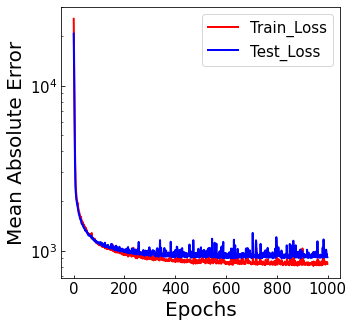

In [83]:
#plt.plot()
plt.figure(figsize=(5,5))
plt.plot(loss_plot[:, 0], loss_plot[:, 1], color='red', linestyle='-', linewidth=2, label='Train_Loss')
plt.plot(loss_plot[:, 0], loss_plot[:, 2], color='b', linestyle='-', linewidth=2, label='Test_Loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Mean Absolute Error', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.legend(loc=1, ncol=1, fontsize=15)
#plt.savefig('loss.jpg', ddpi=100, bbox_inches='tight')
plt.savefig('loss.jpg', bbox_inches='tight')
plt.show()

In [21]:
#np.savetxt('loss.csv', loss_plot, delimiter=',')

# Plot Loss and Accuracy

In [22]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader: 
        inputs = Variable(inputs.float()).to(DEVICE)
        labels = Variable(labels.float()).to(DEVICE)
        outputs = model(inputs)
        #test_loss += F.mse_loss(outputs, labels, reduction='sum').item()
        #pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(device)
        #correct += (pred == target.long()).sum().item()
    #print('test_loss: {:.4f}'.format(test_loss))
    #print('inputs', inputs, '\nlabels', labels, '\noutputs', outputs)

inputs = inputs.cpu()
inputs = inputs.numpy()

labels = labels.cpu()
labels = labels.numpy()

outputs = outputs.cpu()
outputs = outputs.numpy()

np.set_printoptions(suppress=False) #Do not use Kexue Jishufa
#print(inputs, '\n\n', labels, '\n\n', outputs)
print("----------Test Set----------")
print("Input shape: ", inputs.shape)
print("Labels shape: ", labels.shape)
print("Outputs shape: ", outputs.shape)

----------Test Set----------
Input shape:  (578, 2)
Labels shape:  (578, 121)
Outputs shape:  (578, 121)


In [42]:
for check in range(labels.shape[0]):
    print(check, inputs[check,:])
    
#p_max = np.amax(inputs, axis=0)
#print(p_max)

0 [1.9e+16 8.5e+16]
1 [6.1e+16 6.7e+16]
2 [8.8e+16 1.9e+16]
3 [7.3e+16 8.2e+16]
4 [1.9e+16 2.5e+16]
5 [8.2e+16 2.2e+16]
6 [8.2e+16 2.8e+16]
7 [7.0e+16 9.4e+16]
8 [1.3e+16 4.0e+15]
9 [6.7e+16 6.7e+16]
10 [7.9e+16 7.0e+16]
11 [9.1e+16 5.2e+16]
12 [4.9e+16 6.1e+16]
13 [4.9e+16 9.7e+16]
14 [6.4e+16 2.2e+16]
15 [7.6e+16 3.1e+16]
16 [9.4e+16 2.8e+16]
17 [5.5e+16 2.2e+16]
18 [1.9e+16 9.4e+16]
19 [9.1e+16 4.0e+15]
20 [9.7e+16 1.3e+16]
21 [5.8e+16 9.7e+16]
22 [8.5e+16 3.7e+16]
23 [4.0e+15 7.3e+16]
24 [9.7e+16 1.0e+17]
25 [3.4e+16 7.3e+16]
26 [7.0e+16 4.3e+16]
27 [3.7e+16 9.4e+16]
28 [4.3e+16 7.9e+16]
29 [8.8e+16 5.5e+16]
30 [1.e+16 1.e+15]
31 [3.4e+16 7.6e+16]
32 [4.9e+16 7.3e+16]
33 [6.1e+16 7.9e+16]
34 [4.3e+16 9.7e+16]
35 [2.5e+16 4.6e+16]
36 [9.4e+16 2.5e+16]
37 [9.4e+16 6.4e+16]
38 [1.0e+17 9.7e+16]
39 [4.3e+16 1.3e+16]
40 [3.4e+16 4.3e+16]
41 [8.5e+16 9.7e+16]
42 [3.4e+16 4.0e+15]
43 [4.0e+16 3.4e+16]
44 [2.2e+16 7.6e+16]
45 [2.2e+16 8.2e+16]
46 [4.9e+16 2.5e+16]
47 [4.3e+16 4.3e+16]
48 [

416 [7.6e+16 8.2e+16]
417 [2.5e+16 5.8e+16]
418 [8.5e+16 7.0e+15]
419 [5.2e+16 4.3e+16]
420 [8.5e+16 5.2e+16]
421 [4.9e+16 7.0e+15]
422 [6.1e+16 3.7e+16]
423 [3.7e+16 1.0e+17]
424 [1.0e+15 6.7e+16]
425 [4.3e+16 6.1e+16]
426 [4.3e+16 1.6e+16]
427 [1.6e+16 5.5e+16]
428 [6.4e+16 6.4e+16]
429 [4.6e+16 2.8e+16]
430 [8.5e+16 3.1e+16]
431 [9.4e+16 5.8e+16]
432 [3.7e+16 9.7e+16]
433 [2.2e+16 6.1e+16]
434 [1.9e+16 7.0e+16]
435 [2.8e+16 3.1e+16]
436 [1.0e+16 1.6e+16]
437 [9.4e+16 1.0e+15]
438 [6.7e+16 4.0e+16]
439 [3.7e+16 5.8e+16]
440 [1.e+17 4.e+16]
441 [6.1e+16 8.5e+16]
442 [4.3e+16 6.7e+16]
443 [9.7e+16 2.5e+16]
444 [3.1e+16 1.6e+16]
445 [7.0e+15 3.7e+16]
446 [5.8e+16 2.2e+16]
447 [1.0e+17 5.5e+16]
448 [4.6e+16 4.6e+16]
449 [1.0e+15 9.1e+16]
450 [1.0e+15 3.1e+16]
451 [8.2e+16 1.3e+16]
452 [3.7e+16 9.1e+16]
453 [3.1e+16 7.0e+15]
454 [4.0e+16 8.5e+16]
455 [4.3e+16 3.7e+16]
456 [9.1e+16 9.7e+16]
457 [1.3e+16 6.4e+16]
458 [6.4e+16 7.0e+16]
459 [8.8e+16 7.3e+16]
460 [2.8e+16 8.2e+16]
461 [8.5e+16

121


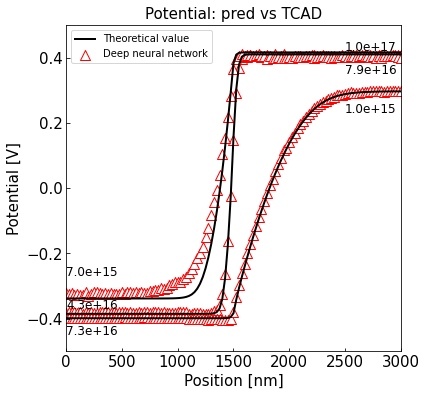

In [96]:
#print(k)
#print("Acceptor Concentration is %e" %(inputs[k,0]))
#print("Donor Concentration is %e" %(inputs[k,1]))

x = np.arange(0, 3025, 25)
print(x.size)

plt.figure(figsize=(6,6))
plt.title('Potential: pred vs TCAD', fontsize=15)


#for l in range(5):
    #k = np.random.randint(0, labels.shape[0])

k1, k2, k3 = 28, 195, 81

plt.scatter(x, outputs[k1, :], s=100, color='w', marker='^', edgecolor='r', label='Deep neural network')
plt.plot(x, labels[k1, :], color='black', linewidth=2, label='Theoretical value')
plt.text(2, -0.37, '{:.1e}'.format(inputs[k1,0]), fontsize=12)
plt.text(2500, 0.35, '{:.1e}'.format(inputs[k1,1]), fontsize=12)

plt.scatter(x, outputs[k2, :], s=100, color='w', marker='^', edgecolor='r')
plt.plot(x, labels[k2, :], color='black', linewidth=2)
plt.text(2, -0.27, '{:.1e}'.format(inputs[k2,0]), fontsize=12)
plt.text(2500, 0.42, '{:.1e}'.format(inputs[k2,1]), fontsize=12)

plt.scatter(x, outputs[k3, :], s=100, color='w', marker='^', edgecolor='r')
plt.plot(x, labels[k3, :], color='black', linewidth=2)
plt.text(2, -0.45, '{:.1e}'.format(inputs[k3,0]), fontsize=12)
plt.text(2500, 0.23, '{:.1e}'.format(inputs[k3,1]), fontsize=12)

plt.xlabel('Position [nm]', fontsize=15)
plt.ylabel('Potential [V]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.legend(loc=2, ncol=1, fontsize=10)
#plt.text(5, 0.6, 'Acceptor Conc.  {:.1e}\nDonor Conc.  {:.1e}'.format(inputs[k1,0],inputs[k1,1]), fontsize=10)
plt.axis([0, 3000, -0.5, 0.5])
plt.savefig('potential.jpg', bbox_inches='tight')
plt.show()

In [28]:
end = time.perf_counter()
print('Running time is ', end-start)

Running time is  56.45703680533916
